In [118]:
import ast
import json
import math
from os import path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from Bio import SeqIO

# Figure 3: Rates of adaptation across the genomes of a diverse range of human pathogenic viruses

Plot the estimated rate of adaptation in all genes of the genome, for a handful of viruses, spanning different viral families, genome types and transmission modes

In [2]:
def readin_virus_config(virus):
    config_json = f'config/adaptive_evo_config_{virus}.json'

    with open(config_json) as json_handle:
        configs = json.load(json_handle)
        
    return configs

In [358]:
def get_rates(virus_and_subtype):
    """
    Get rates of adaptation for each gene in the genome
    Return rates and 95CIs given in adaptive muts per codon per year x10-3
    """
    
    rates_by_gene = {}
    
    if '_' in virus_and_subtype:
        virus = virus_and_subtype.split('_')[0]
    else:
        virus = virus_and_subtype
    
    configs = readin_virus_config(virus)
    genes = configs['genes']
    
    for gene in genes:
        bhatt_json_name = f'bhatt_results_nextstrain/{virus_and_subtype}_{gene}_bhatt_analysis_bootstrapped.json'
        if path.exists(bhatt_json_name):
            with open(bhatt_json_name) as bhatt_handle:
                json_dict = json.load(bhatt_handle)
                (bhatt_window_midpoint, bhatt_adaptive_substitutions, 
                 bhatt_adaptive_substitutions_per_codon, 
                 bhatt_rate_of_adaptation, bhatt_bootstrap_adaptive_substitutions, 
                 bhatt_bootstrap_adaptive_substitutions_per_codon, 
                 bhatt_bootstrap_rate_of_adaptation) = (json_dict['window_midpoint'], 
                                                  json_dict['adaptive_substitutions'], 
                                                  json_dict['adaptive_substitutions_per_codon'], 
                                                  json_dict['rate_of_adaptation'], 
                                                  json_dict['bootstrap_adaptive_substitutions'], 
                                                  json_dict['bootstrap_adaptive_substitutions_per_codon'], 
                                                  json_dict['bootstrap_rate_of_adaptation'])
                
            bs_slope_sci = [x * (10**3) for x in bhatt_bootstrap_rate_of_adaptation]
            lower_95ci = np.percentile(sorted(bs_slope_sci), 2.5)
            upper_95ci = np.percentile(sorted(bs_slope_sci), 97.5)
            
        rates_by_gene[gene.upper()] = {'rate':bhatt_rate_of_adaptation* (10**3), 'upper_95ci':upper_95ci, 
                               'lower_95ci':lower_95ci}

    
    return rates_by_gene

In [276]:
def get_genome_coordinates_segmented(virus):
    """
    For a segmented virus, get all the segment lengths and gene positions
    Return the positions of the rectangles that should be plotted for the genome cartoon, 
    as well as the position each rate should be plotted at (centered in gene)
    """
    
    configs = readin_virus_config(virus)
    genes = configs['genes']
    #order genes based on segment numbering
    if virus in ['h3n2', 'h1n1pdm', 'vic', 'yam']:
        genes = ['PB2', 'PB1', 'PA', 'ha1', 'ha2', 'NP', 'NA']
    
    #for each gene in a segmented genome, get which segment it is on, and it's position within the segment
    gene_positions = {}
    
    #keep track of the lengths of all segments
    segments_seen = []
    segment_lengths = {}
    
    
    
    for gene in genes:
        if configs['receptor_binding']['virus_gene'] == gene:
            if 'specify_location' in configs['receptor_binding'].keys():
                parent_gene = configs['receptor_binding']['specify_location']['parent_gene']
                gene_location = ast.literal_eval(configs['receptor_binding']['specify_location']['location'])[0]
                #get the length of the full segment
                reference_file = configs['reference_file'].format(virus=virus, gene=parent_gene)
                for seq_record in SeqIO.parse(reference_file, "genbank"):
                    segment_length = len(seq_record.seq)
                    
                gene_positions[gene] = {'segment': parent_gene.upper(), 'segment_length':segment_length, 
                        'location': gene_location}
                if parent_gene not in segments_seen:
                    segments_seen.append(parent_gene)
                    segment_lengths[parent_gene] = segment_length

                    
                
        elif configs['membrane_fusion']['virus_gene'] == gene:
            if 'specify_location' in configs['membrane_fusion'].keys():
                parent_gene = configs['membrane_fusion']['specify_location']['parent_gene']
                gene_location = ast.literal_eval(configs['membrane_fusion']['specify_location']['location'])[0]
                #get the length of the full segment
                reference_file = configs['reference_file'].format(virus=virus, gene=parent_gene)
                for seq_record in SeqIO.parse(reference_file, "genbank"):
                    segment_length = len(seq_record.seq)
                    
                gene_positions[gene] = {'segment': parent_gene.upper(), 'segment_length':segment_length, 
                                        'location': gene_location}
                if parent_gene not in segments_seen:
                    segments_seen.append(parent_gene)
                    segment_lengths[parent_gene] = segment_length
        
        
        else:
            reference_file = configs['reference_file'].format(virus=virus, gene=gene)
            gene_location=False

            for seq_record in SeqIO.parse(reference_file, "genbank"):
                segment_length = len(seq_record.seq)
                for feature in seq_record.features:
                    if feature.type == 'CDS':
                        if 'gene' in feature.qualifiers.keys():
                            if feature.qualifiers['gene'][0].lower() == gene.lower():
                                gene_location = [int(feature.location.start), int(feature.location.end)]
                        if gene_location==False:
                            if 'product' in feature.qualifiers.keys():
                                if feature.qualifiers['product'][0].lower() == gene.lower():
                                    gene_location = [int(feature.location.start), int(feature.location.end)]
                        if gene_location == False:
                            if 'locus_tag' in feature.qualifiers.keys():
                                if feature.qualifiers['locus_tag'][0].lower() == gene.lower():
                                    gene_location = [int(feature.location.start), int(feature.location.end)]

            gene_positions[gene] = {'segment': gene, 'segment_length':segment_length, 'location': gene_location}
            if gene not in segments_seen:
                segments_seen.append(gene)
                segment_lengths[gene] = segment_length
    
    
    #get the total length of the all segments in the genome
    total_genome_len = sum([v for k,v in segment_lengths.items()])
    
    #get the total size of the genome cartoon, including space between each segment
    space_between_segments = total_genome_len*.05
    total_len_cartoon = total_genome_len + (space_between_segments*(len(segment_lengths)-1))
    
    #get normalization factor to normalize genome to a total width of 8
    normalization = 8/total_len_cartoon
    space_between_segments_normalized = space_between_segments*normalization
                
                
    #get positions to plot genome cartoon
    last_segment_pos = 0
    #segments will be shown as dark boxes
    dark_boxes = {}
    for s, l in segment_lengths.items():
        normalized_len = l*normalization
        end_of_segment = last_segment_pos+normalized_len
        dark_boxes[s.upper()] = [last_segment_pos, end_of_segment]
        increase_x = space_between_segments_normalized + normalized_len
        last_segment_pos+=increase_x

    #genes within segment will be shown as lighter boxes, these will be labeled
    #rates will be plotted at the midpoint of their gene
    last_gene_pos = 0
    light_boxes = {}
    rate_positions = {}
    for g, p in gene_positions.items():
        #find start location of segment
        segment_start = dark_boxes[p['segment']][0]
        gene_start_normalized = segment_start + p['location'][0]*normalization
        gene_end_normalized = segment_start + p['location'][1]*normalization
        light_boxes[g.upper()] = [gene_start_normalized, gene_end_normalized]
        rate_plot_position = (gene_start_normalized + gene_end_normalized)/2
        rate_positions[g.upper()] = rate_plot_position
        
    
    
    return dark_boxes, light_boxes, rate_positions

In [386]:
def get_genome_coordinates_linear(virus_and_subtype):
    """
    For virus with a linear (unsegmented) genome, get the position of each gene, 
    and return where to draw boxes denoting the whole genome ("dark") and each gene ("light")
    """
    
    if '_' in virus_and_subtype:
        virus = virus_and_subtype.split('_')[0]
        subtype = virus_and_subtype.split('_')[1]
    else:
        virus = virus_and_subtype
        subtype = None
    
    configs = readin_virus_config(virus)
    genes = configs['genes']

    
    #store gene positions
    gene_positions = {}
    
    for gene in genes:
        reference_file = configs['reference_file'].format(virus=virus, gene='genome')
        gene_location=False

        for seq_record in SeqIO.parse(reference_file, "genbank"):
            genome_length = len(seq_record.seq)
            for feature in seq_record.features:
                if feature.type == 'CDS':
                    if 'gene' in feature.qualifiers.keys():
                        if feature.qualifiers['gene'][0].lower() == gene.lower():
                            gene_location = [int(feature.location.start), int(feature.location.end)]
                    if gene_location==False:
                        if 'product' in feature.qualifiers.keys():
                            if feature.qualifiers['product'][0].lower() == gene.lower():
                                gene_location = [int(feature.location.start), int(feature.location.end)]
                    if gene_location == False:
                        if 'locus_tag' in feature.qualifiers.keys():
                            if feature.qualifiers['locus_tag'][0].lower() == gene.lower():
                                gene_location = [int(feature.location.start), int(feature.location.end)]
                                
        gene_positions[gene] = gene_location
        
    #get normalization factor to normalize genome to a total width of 8
    normalization = 8/genome_length
    
    #whole genome will be shown as a darker box
    dark_boxes = {'genome': [0,genome_length*normalization]}
    
    #each gene will be shown as a lighter box and labeled with gene name
    #rates will be plotted at the midpoint of the gene
    light_boxes = {}
    rate_positions = {}
    for g, p in gene_positions.items():
        light_boxes[g.upper()] = [p[0]*normalization, p[1]*normalization]
        rate_positions[g.upper()] = (p[0]*normalization + p[1]*normalization)/2


    return dark_boxes, light_boxes, rate_positions

In [308]:
#make the virus name more legible
legible_titles_viruses = {'rsv_A': 'RSV-A', 'rsv_B': 'RSV-B', 
                         '229e': '229E', 'oc43_A': 'OC43-A', 
                         'oc43_B': 'OC43-B', 'nl63': 'NL63', 
                          'measles': 'Measles', 'h3n2': 'H3N2', 'vic': 'B/Vic', 'yam': 'B/Yam',
                          'enterovirusd68': 'Enterovirus D68', 'norovirus': 'Norovirus GII.4', 
                          'hepatitisB_A2':'hepatitisB-A2', 
                          'hepatitisB_C':'hepatitisB-C','hepatitisB_D3':'hepatitisB-D3', 
                          'rhinovirusA101':'Rhinovirus A101', 'rhinovirusB6': 'Rhinovirus B6',
                          'hepatitisA_IA': 'Hepatitis A-IA', 'hepatitisA_IB': 'Hepatitis A-IB'}

In [390]:
def plot_rate_on_genome_cartoon(viruses):
    """
    For each virus, plot a cartoon of it's genome (or at least of the parts where rates were calculated)
    Above the cartoon, plot the rate of adaptation in this gene
    """
    
    num_rows_to_plot = int(round(len(viruses)/2))
    
    #plot styling
    sns.set_style("white")
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['axes.labelweight'] = 'bold'
    plt.rcParams['axes.titlesize'] = 12
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    plt.rcParams['legend.fontsize'] = 8
    plt.rcParams['figure.dpi']= 300
    
    #initiate plot with one axis per virus
    fig, axs = plt.subplots(num_rows_to_plot, 2, figsize=(8,2.5*(num_rows_to_plot)), sharey=False)
    
    #figure panel labels
    fig_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
    
    #make a subplot for each virus
    for v in range(len(viruses)):
        virus_and_subtype = viruses[v]
        
        if '_' in virus_and_subtype:
            virus = virus_and_subtype.split('_')[0]
            subtype = virus_and_subtype.split('_')[1]
        else:
            virus = virus_and_subtype
            subtype = None
        
        configs = readin_virus_config(virus)
        if subtype:
            color = configs['color'][subtype]
        else:
            color= configs['color']
        #get axis coordinates
        j=0
        if v%2!=0:
            j = 1
        i = math.floor(v/2)
        fig_index = 2*i+j
        
        #add figure panel labels
        axs[i, j].text(-0.12, 1.0, fig_labels[fig_index], horizontalalignment='center', 
                       verticalalignment='center', weight='bold', fontsize=16, transform=axs[i, j].transAxes)
        
        #get rates of adaptation for each gene in this virus
        rates_by_gene = get_rates(virus_and_subtype)
        
        #get genome positions for cartoon
        if virus_and_subtype in ['h3n2', 'h1n1pdm', 'vic', 'yam']:
            (dark_boxes, light_boxes, rate_positions) = get_genome_coordinates_segmented(virus_and_subtype)
        elif virus_and_subtype in ['oc43_A', '229e', 'measles', 'enterovirusd68', 
                                   'hepatitisA_IA', 'hepatitisB_A2' 'adenovirusB7']:
            (dark_boxes, light_boxes, rate_positions) = get_genome_coordinates_linear(virus_and_subtype)
        else:
            'need to input whether virus is segmented or not'
        
        #plot the rates of adaptation for each gene at the midpoint of the gene (on x-axis)
        for gene, x_pos in rate_positions.items():
            rate = rates_by_gene[gene]['rate']
            err_lower = rates_by_gene[gene]['lower_95ci']
            err_upper = rates_by_gene[gene]['upper_95ci']
                
            #plot rate of adaptation and 95CI
            axs[i, j].plot(x_pos, rate, 'o', ms=10, color=color)
            axs[i, j].vlines(x_pos, err_lower, err_upper, color=color)
            
            axs[i, j].annotate(gene, (x_pos, -1.75), color='black', ha='center', va='center', size=6)
            
        #plot a rectangle for each segment along the x-axis
        for gene, box_pos in dark_boxes.items():
            box_start = box_pos[0]
            box_end = box_pos[1]
            box_width = box_end-box_start
            axs[i, j].add_patch(plt.Rectangle((
                box_start,-2.0), box_width, 0.65, color="#808080"))
            
        #plot a rectangle for each gene along the x-axis
        for gene, box_pos in light_boxes.items():
            box_start = box_pos[0]
            box_end = box_pos[1]
            box_width = box_end-box_start
            axs[i, j].add_patch(plt.Rectangle((
                box_start,-2.0), box_width, 0.65, color="#d3d3d3"))
        
        #remove all xticks
        axs[i, j].set_xticks([]) 
        #specify yticks, otherwise will include negative numbers because of the genome cartoon
        axs[i, j].set_yticks([0,1,2,3,4,5]) 
        #label the virus that is being plotted
        axs[i, j].text(0.15, 0.9, legible_titles_viruses[virus_and_subtype], fontsize=16, horizontalalignment='center', 
                   verticalalignment='center', transform=axs[i, j].transAxes)

                
    sns.despine(bottom=True)
    
    
    fig.tight_layout()
    


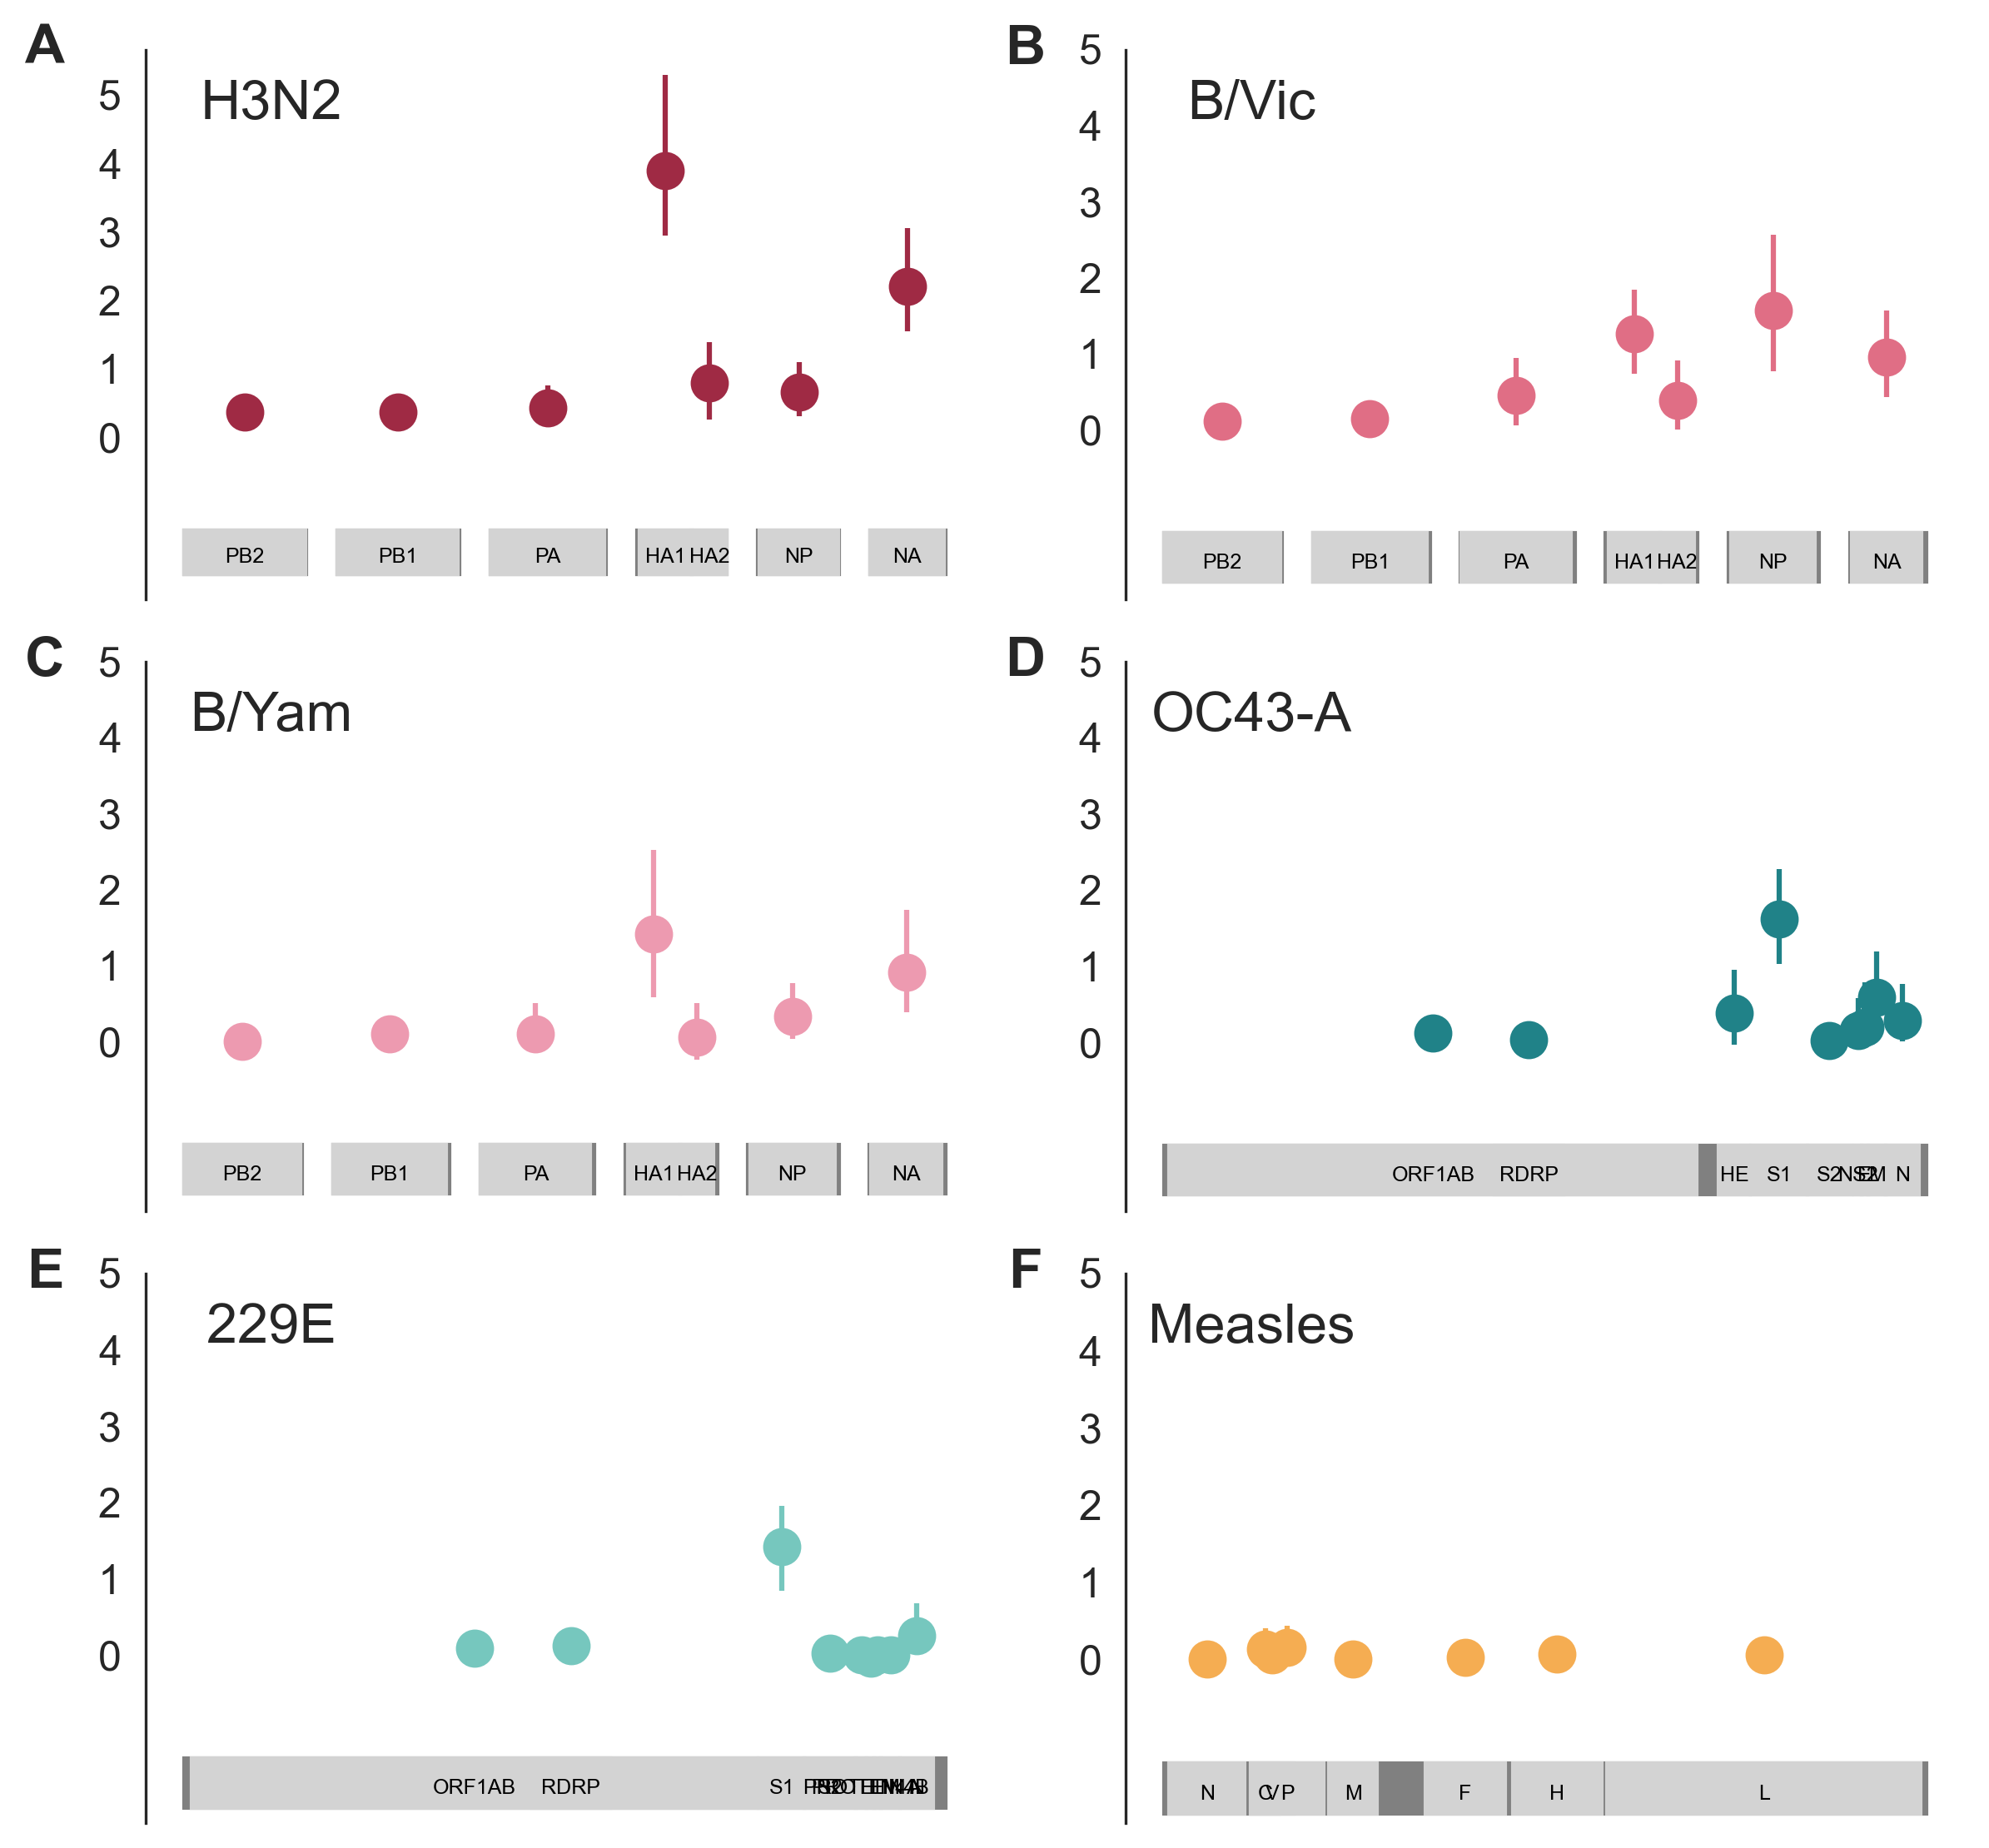

In [392]:
plot_rate_on_genome_cartoon(['h3n2', 'vic', 'yam', 'oc43_A', '229e', 'measles'])